In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean
from cmcrameri import cm
import pop_tools

In [36]:
import cartopy.mpl.ticker as cticker

In [2]:
# da1 = xr.open_dataset('/Volumes/kyy_raid/kimyy/Model/CESM2/ESP/LENS2/archive_analysis/ocn/SSH/ens_smbb/test.nc')
# ssh  = da1.SSH.load()
#ts = da1.SSH.mean(('nlat', 'nlon')).groupby('time.year').mean()#.plot()
#ts.plot()
# uvel = da1.cmems_u.mean('time').load()
# vvel = da1.cmems_v.mean('time').load()
# levels=np.arange(-0.5, 0.5, 0.1)
# levels

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
ds_grid = pop_tools.get_grid('POP_gx1v7')
# ds.info()

In [28]:
da2 = xr.open_dataset('/Volumes/kyy_raid/kimyy/Model/CESM2/ESP/LENS2/archive_analysis/ocn/SSH/ens_smbb/test.nc')
da1 = xr.open_mfdataset('/Volumes/kyy_raid/kimyy/Model/CESM2/ESP/LENS2/archive_analysis/ocn/SSH/ens_smbb/SSH_ensmean_????-??.nc', combine='nested', concat_dim='time')

In [29]:
da2

<xarray.Dataset>
Dimensions:    (time: 792, bnds: 2, nlat: 384, nlon: 320)
Coordinates:
  * time       (time) object 1960-02-01 00:00:00 ... 2026-01-01 00:00:00
    TLONG      (nlat, nlon) float64 ...
    TLAT       (nlat, nlon) float64 ...
Dimensions without coordinates: bnds, nlat, nlon
Data variables:
    time_bnds  (time, bnds) object ...
    SSH        (time, nlat, nlon) float32 ...
Attributes: (12/13)
    CDI:               Climate Data Interface version 2.3.0 (https://mpimet.m...
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    source:            CCSM POP2, the CCSM Ocean Component
    title:             b.e21.BHISTsmbb.f09_g17.LE2-1011.001
    history:           Tue Aug 20 13:50:21 2024: cdo mergetime SSH_ensmean_19...
    time_period_freq:  month_1
    ...                ...
    contents:          Diagnostic and Prognostic Variables
    revision:          $Id$
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2021-03-19 at 09:24:42.6
    cell_methods:      cell_methods = time: mean ==> the variable values are ...
    CDO:               Climate Data Operators version 2.3.0 (https://mpimet.m...

In [30]:
da1

<xarray.Dataset>
Dimensions:    (time: 792, bnds: 2, nlat: 384, nlon: 320)
Coordinates:
  * time       (time) object 1960-02-01 00:00:00 ... 2026-01-01 00:00:00
    TLONG      (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT       (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
Dimensions without coordinates: bnds, nlat, nlon
Data variables:
    time_bnds  (time, bnds) object dask.array<chunksize=(1, 2), meta=np.ndarray>
    SSH        (time, nlat, nlon) float32 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
Attributes: (12/13)
    CDI:               Climate Data Interface version 2.1.1 (https://mpimet.m...
    source:            CCSM POP2, the CCSM Ocean Component
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    title:             b.e21.BHISTsmbb.f09_g17.LE2-1011.001
    history:           Tue Apr 18 00:54:31 2023: cdo -O -w -z zip_5 -ensmean ...
    time_period_freq:  month_1
    ...                ...
    contents:          Diagnostic and Prognostic Variables
    revision:          $Id$
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2021-03-19 at 09:24:42.6
    cell_methods:      cell_methods = time: mean ==> the variable values are ...
    CDO:               Climate Data Operators version 2.1.1 (https://mpimet.m...

In [7]:
ssh = da1.SSH.mean('time').load()

In [9]:
ssh = ssh.assign_coords(TLONG=ds_grid.TLONG)
ssh = ssh.assign_coords(TLAT=ds_grid.TLAT)

In [14]:
def pop_add_cyclic(da):
    #copied from Mattew Longs github (https://gist.github.com/matt-long/50433da346da8ac17cde926eec90a87c) and modified for DA
    #This doesn't work with Dask (DA should be loaded)
    #Input DA must have the name and coords (TLONG and TLAT), and don't have other dims (time etc.)
    #Output is DA
    nj = da.TLAT.shape[0]
    ni = da.TLONG.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)
    tlon = da.TLONG.data
    tlat = da.TLAT.data
    tlon = np.where(np.greater_equal(tlon, min(tlon[:,0])), tlon-360., tlon)
    lon  = np.concatenate((tlon, tlon + 360.), 1)
    lon = lon[:, xL:xR]
    if ni == 320:
        lon[367:-3, 0] = lon[367:-3, 0] + 360.
    lon = lon - 360.
    lon = np.hstack((lon, lon[:, 0:1] + 360.))
    if ni == 320:
        lon[367:, -1] = lon[367:, -1] - 360.
    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:, 0] = lon[:, 0] - 1e-8
    #-- periodicity
    lat = np.concatenate((tlat, tlat), 1)
    lat = lat[:, xL:xR]
    lat = np.hstack((lat, lat[:,0:1]))
    TLAT = xr.DataArray(lat, dims=('nlat', 'nlon'))
    TLONG = xr.DataArray(lon, dims=('nlat', 'nlon'))
    # copy vars
    v = da.name
    v_dims = da.dims
    # determine and sort other dimensions
    other_dims = set(v_dims) - {'nlat', 'nlon'}
    other_dims = tuple([d for d in v_dims if d in other_dims])
    lon_dim = da.dims.index('nlon')
    field = da.data
    field = np.concatenate((field, field), lon_dim)
    field = field[:, xL:xR]
    field = np.concatenate((field, field[:, 0:1]), lon_dim)
    dao = xr.DataArray(field, dims=other_dims+('nlat', 'nlon'), attrs=da.attrs)
    dao = dao.assign_coords(TLONG=TLONG)
    dao = dao.assign_coords(TLAT=TLAT)
    return dao


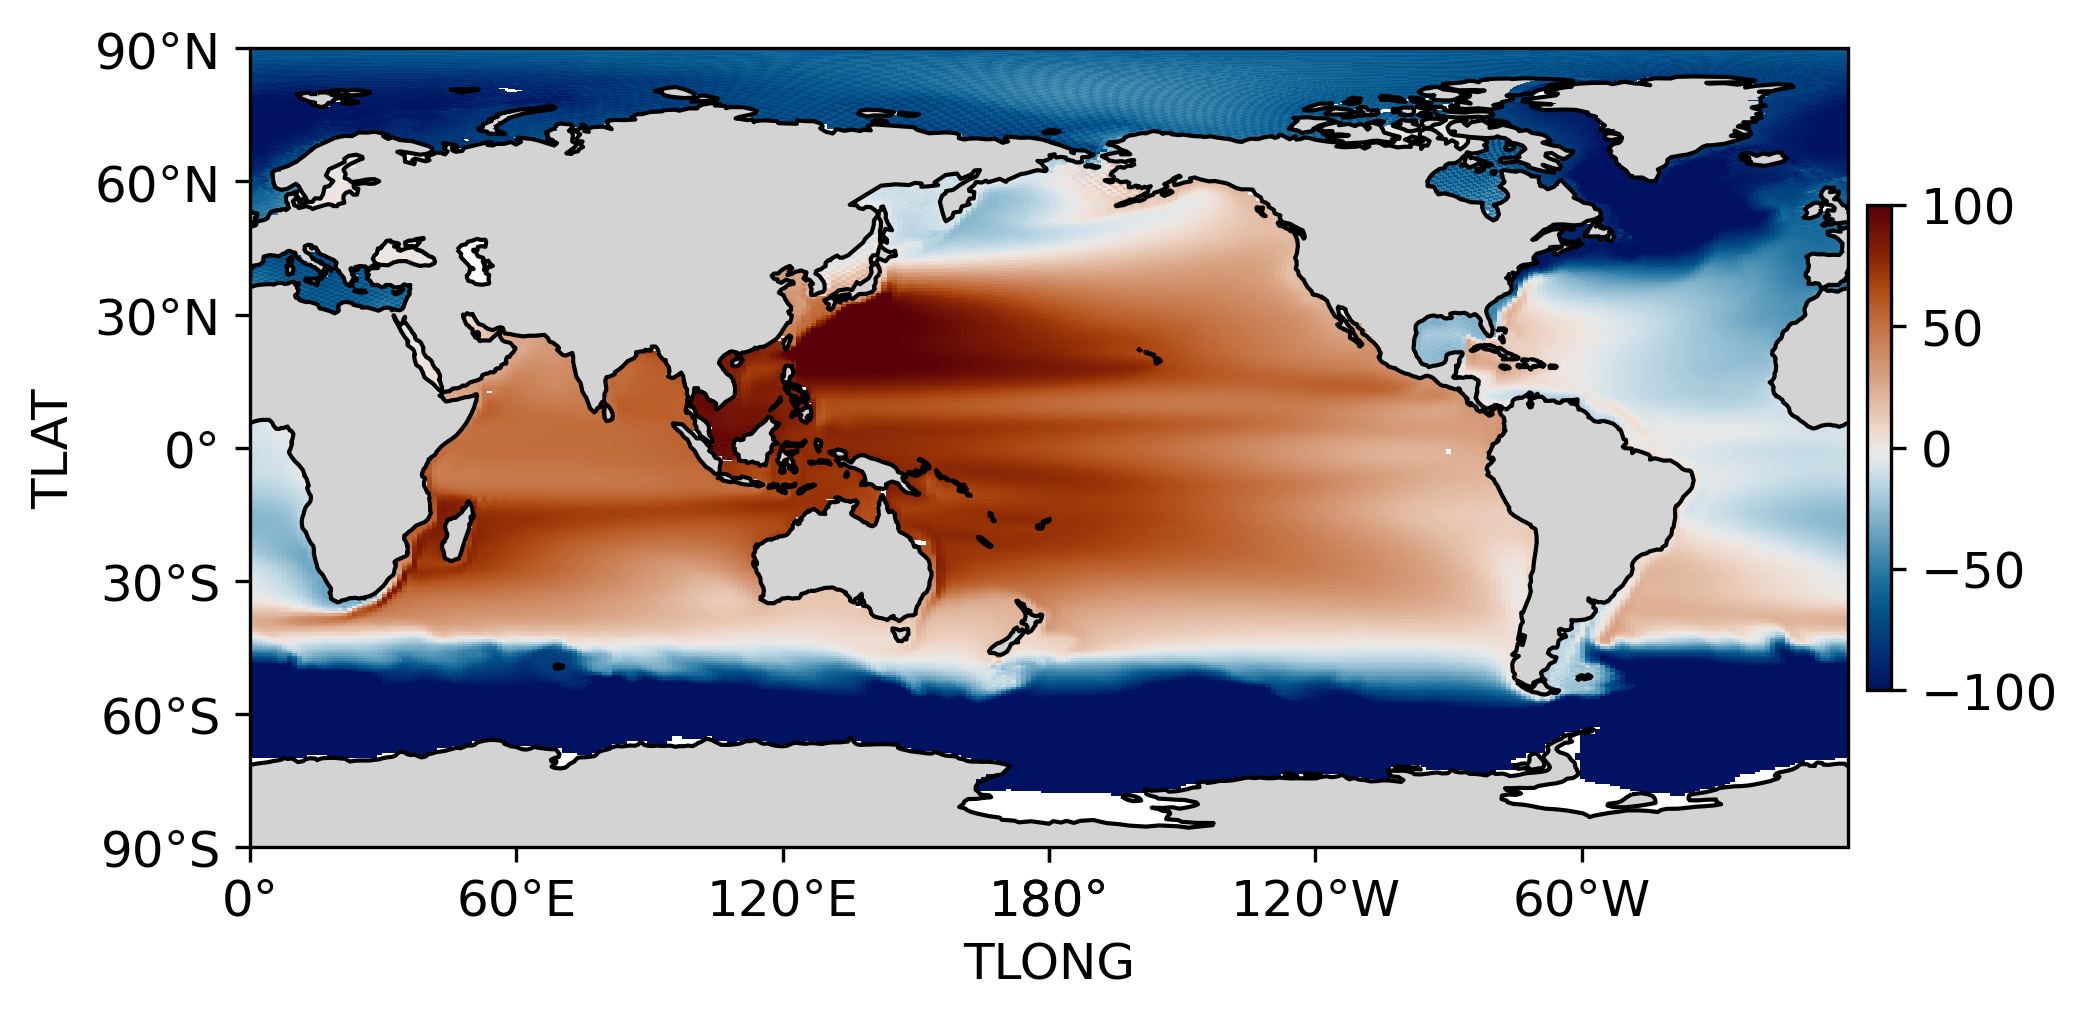

In [38]:
plt.rcParams["font.size"] = 12
proj=ccrs.PlateCarree(central_longitude=180)
# proj=ccrs.Robinson(cnetral_longitude=180)
fig=plt.figure(figsize=(18,7), dpi=300)
ax=plt.subplot(121, projection=proj)
ax.add_feature(cfeature.LAND,linewidth=0.5, color='lightgrey')
ax.coastlines()
#ss=pop_add_cyclic(ssh).plot.contourf(ax = ax, x='TLONG', y='TLAT',cmap=cm.vik, levels=np.arange(-100,100,10), transform=ccrs.PlateCarree(), extend='both', add_colorbar=False)
ss=pop_add_cyclic(ssh).plot.pcolormesh(ax = ax, x='TLONG', y='TLAT',cmap=cm.vik, vmax=100, vmin=-100, transform=ccrs.PlateCarree(), add_colorbar=False)
plt.colorbar(ss, shrink=0.3, pad=0.01)

ax.set_xticks(np.arange(-180,181,60), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)

# Define the yticks for latitude
ax.set_yticks(np.arange(-90,91,30), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)

array([-5.00000000e-01, -4.00000000e-01, -3.00000000e-01, -2.00000000e-01,
       -1.00000000e-01, -1.11022302e-16,  1.00000000e-01,  2.00000000e-01,
        3.00000000e-01,  4.00000000e-01])

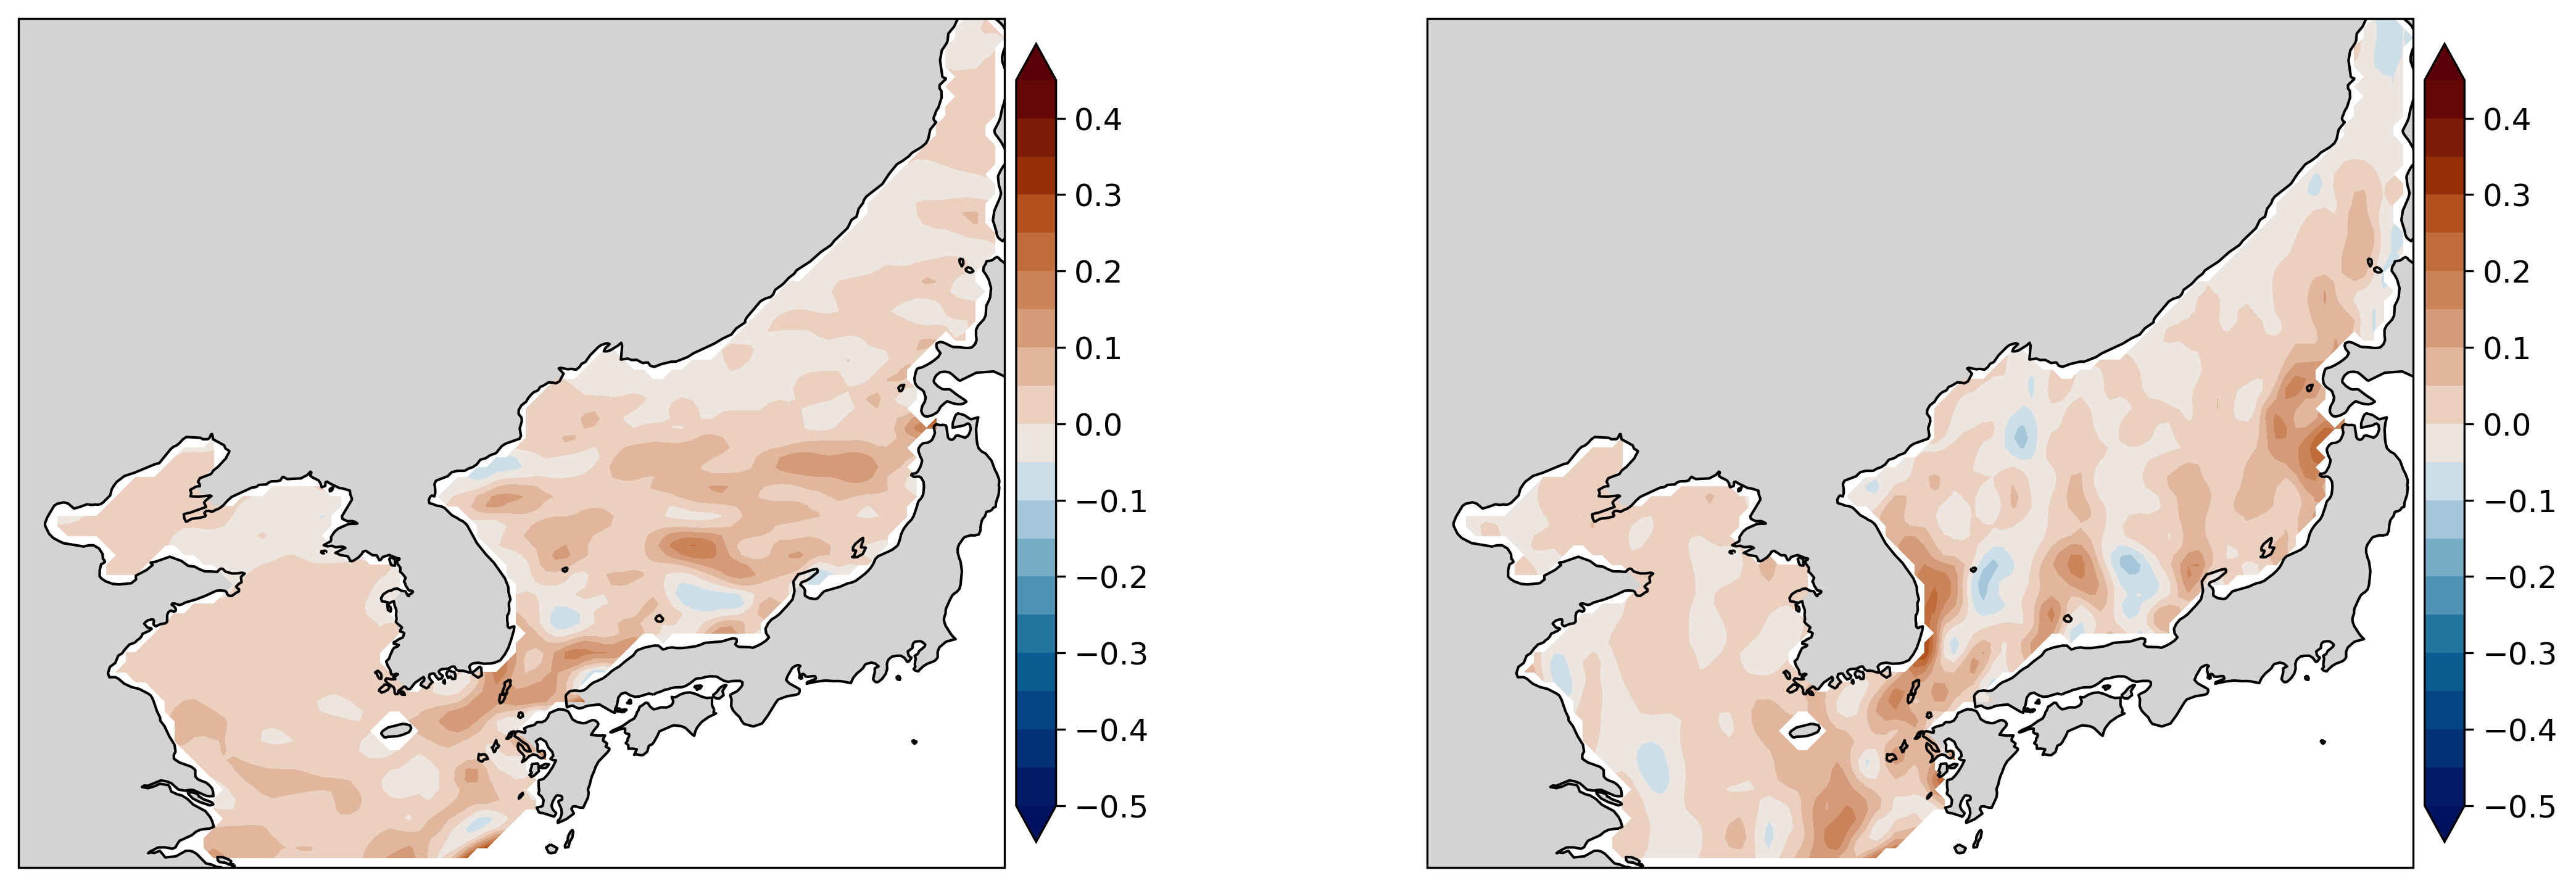

In [85]:
# plt.rcParams["font.size"] = 12
# proj=ccrs.PlateCarree(central_longitude=180)
# # proj=ccrs.Robinson(cnetral_longitude=180)
# fig=plt.figure(figsize=(18,7), dpi=300)
# ax=plt.subplot(121, projection=proj)
# ax.add_feature(cfeature.LAND,linewidth=0.5, color='lightgrey')
# ax.coastlines()

# plt.contourf(uvel.lon, uvel.lat, uvel, transform=ccrs.PlateCarree(), levels=np.arange(-0.5, 0.5, 0.05), cmap=cm.vik, extend='both')
# plt.colorbar(shrink=0.8, pad=0.01)
# #--------
# ax=plt.subplot(122, projection=proj)
# ax.add_feature(cfeature.LAND,linewidth=0.5, color='lightgrey')
# ax.coastlines()

# plt.contourf(uvel.lon, uvel.lat, vvel, transform=ccrs.PlateCarree(), levels=np.arange(-0.5, 0.5, 0.05), cmap=cm.vik, extend='both')
# plt.colorbar(shrink=0.8, pad=0.01)





# Q=plt.quiver(da1.lon[::4], da1.lat[::4], da1.mean_cmems_u[::4, ::4], da1.mean_cmems_v[::4, ::4], scale=250, color='black', width=0.0015, transform=ccrs.PlateCarree())
# Q=plt.quiver(da1.lon, da1.lat, da1.mean_cmems_u, da1.mean_cmems_v, scale=250, color='black', width=0.0015, transform=ccrs.PlateCarree())
# qk=plt.quiverkey(Q,0.9,-0.1,8,'10 m/s',labelpos='N')